# Does it really rain a lot in Seattle?
Author: Joshua Goldberg  
Date: 2020-04-22

When people speak about places to live and visit, a few things come to mind almost immediately: culture, food, and __weather__. Seattle might as well be a synonym for rain. While I was looking to relocate to Seattle, my friends almost universally responded "it rains a lot there." I have spent several years and Chicago. Chicago has its grey, rainy days, so I was not deterred by these comments. While I won't be comparing Chicago to Seattle, this post will generally explore the rain patterns of Seattle to find out if the anecdotes are true.

A few questions come to mind as it pertains to weather in Seattle:

- What frequency does it rain?
- How much actual rainfall occurs (measured in percipitation/inches)?
- Are there seasonal trends of rain?
- Can we predict whether it will rain on a given day with the available data?

While I won't include national data in this exploration, I will try to compare Seattle results to national averages.

In [773]:
import numpy as np
import pandas as pd
import collections
import random
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import seaborn as sns
from tabulate import tabulate
%matplotlib inline

dpi_value = 125

In [774]:
weather_df = pd.read_csv("seattleWeather_1948-2017.csv", parse_dates=True, squeeze=True)
weather_df.columns = map(str.lower, weather_df.columns)

The [data](https://www.kaggle.com/rtatman/did-it-rain-in-seattle-19482017) we will use for this analysis is a time series from 1948-2017 with the following:

- `date`: date associated with weather metrics
- `prcp`: percipitation in inches
- `tmax`: max temperature (Fahrenheit)
- `tmin`: minimum temperature (Fahrenheit)
- `rain`: whether it rained or not

In [775]:
weather_df.head()

,date,prcp,tmax,tmin,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [776]:
weather_df.dtypes

date     object
prcp    float64
tmax      int64
tmin      int64
rain     object
dtype: object

We will convert the date column to a datetime object so we can perform analysis with respect to time. Additionally, we will add some features of dates for later use.

In [777]:
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['day'] = [d.day for d in weather_df.date]
weather_df['month'] = [d.month for d in weather_df.date]
weather_df['year'] = [d.year for d in weather_df.date]
weather_df = weather_df[['date', 'year', 'month', 'day', 'prcp', 'tmax', 'tmin', 'rain']]
weather_df.head()

,date,year,month,day,prcp,tmax,tmin,rain
0,1948-01-01,1948,1,1,0.47,51,42,True
1,1948-01-02,1948,1,2,0.59,45,36,True
2,1948-01-03,1948,1,3,0.42,45,35,True
3,1948-01-04,1948,1,4,0.31,45,34,True
4,1948-01-05,1948,1,5,0.17,45,32,True


In [778]:
weather_df.shape

(25551, 8)

In [779]:
weather_df.describe()

,year,month,day,prcp,tmax,tmin
count,25551.000000,25551.000000,25551.000000,25548.000000,25551.000000,25551.000000
mean,1982.476694,6.519197,15.725060,0.106222,59.544206,44.514226
std,20.193095,3.447046,8.800395,0.239031,12.772984,8.892836
min,1948.000000,1.000000,1.000000,0.000000,4.000000,0.000000
25%,1965.000000,4.000000,8.000000,0.000000,50.000000,38.000000
50%,1982.000000,7.000000,16.000000,0.000000,58.000000,45.000000
75%,2000.000000,10.000000,23.000000,0.100000,69.000000,52.000000
max,2017.000000,12.000000,31.000000,5.020000,103.000000,71.000000


Missing values do not look significant since we have 25,551 rows and only three rows are missing in the `prcp` and `rain` column. We will leave these missing values alone for now until they pose a problem.

In [780]:
weather_df[weather_df.prcp.isnull()]

,date,year,month,day,prcp,tmax,tmin,rain
18415,1998-06-02,1998,6,2,NaN,72,52,NaN
18416,1998-06-03,1998,6,3,NaN,66,51,NaN
21067,2005-09-05,2005,9,5,NaN,70,52,NaN


Here are general time series plots of the numeric data (percipitation and temperature). We filter by the last few years to make it easier to notice any patterns. With our first look, we can see some seasonality in precipitation and temperature (both of somewhat expected depending on the region).

In [781]:
washington_colors = ['#37835a', '#fad64e']

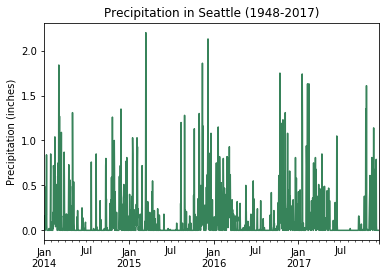

In [782]:
plot = weather_df[weather_df['year'] >= 2014].plot(x='date', y='prcp', color=washington_colors[0], legend=False)
plt.title('Precipitation in Seattle (1948-2017)')
plt.xlabel(None)
plt.ylabel('Precipitation (inches)')
fig = plot.get_figure()
fig.savefig('output.png', dpi=dpi_value)

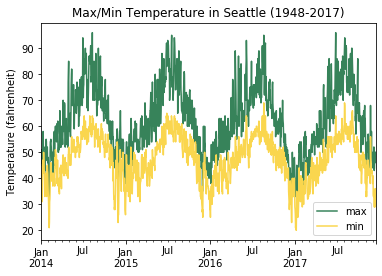

In [783]:
plot = weather_df[weather_df['year'] >= 2014].plot(x='date', y=['tmax', 'tmin'], color=washington_colors)
plt.title('Max/Min Temperature in Seattle (1948-2017)')
plt.xlabel(None)
plt.ylabel('Temperature (fahrenheit)')
plt.legend(['max', 'min'])
fig = plot.get_figure()
fig.savefig('output2.png', dpi=dpi_value)

## What frequency does it rain in Seattle?

In [784]:
proportion_df = pd.DataFrame(weather_df['rain'].value_counts() / weather_df.shape[0]).reset_index()
proportion_df = proportion_df.rename(columns={'index': 'rain', 'rain': 'proportion'})

It rained ~43% of the time in Seattle from 1948-2017.

In [785]:
from itertools import cycle, islice
my_colors = list(islice(cycle(washington_colors), None, len(proportion_df)))

In [786]:
proportion_df

,rain,proportion
0,False,0.573285
1,True,0.426598


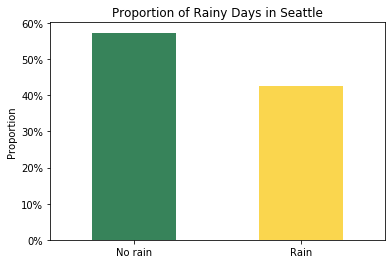

In [787]:
plot = proportion_df.plot(x='rain', y='proportion', kind='bar', rot=0, color=washington_colors, legend=False)
plt.title('Proportion of Rainy Days in Seattle')
plt.xlabel(None)
plt.ylabel('Proportion')
plot.set_xticklabels(['No rain', 'Rain'])
vals = plot.get_yticks()
plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
fig = plot.get_figure()
fig.savefig('output3.png', dpi=dpi_value)

How does this compare to the rest of the U.S.?

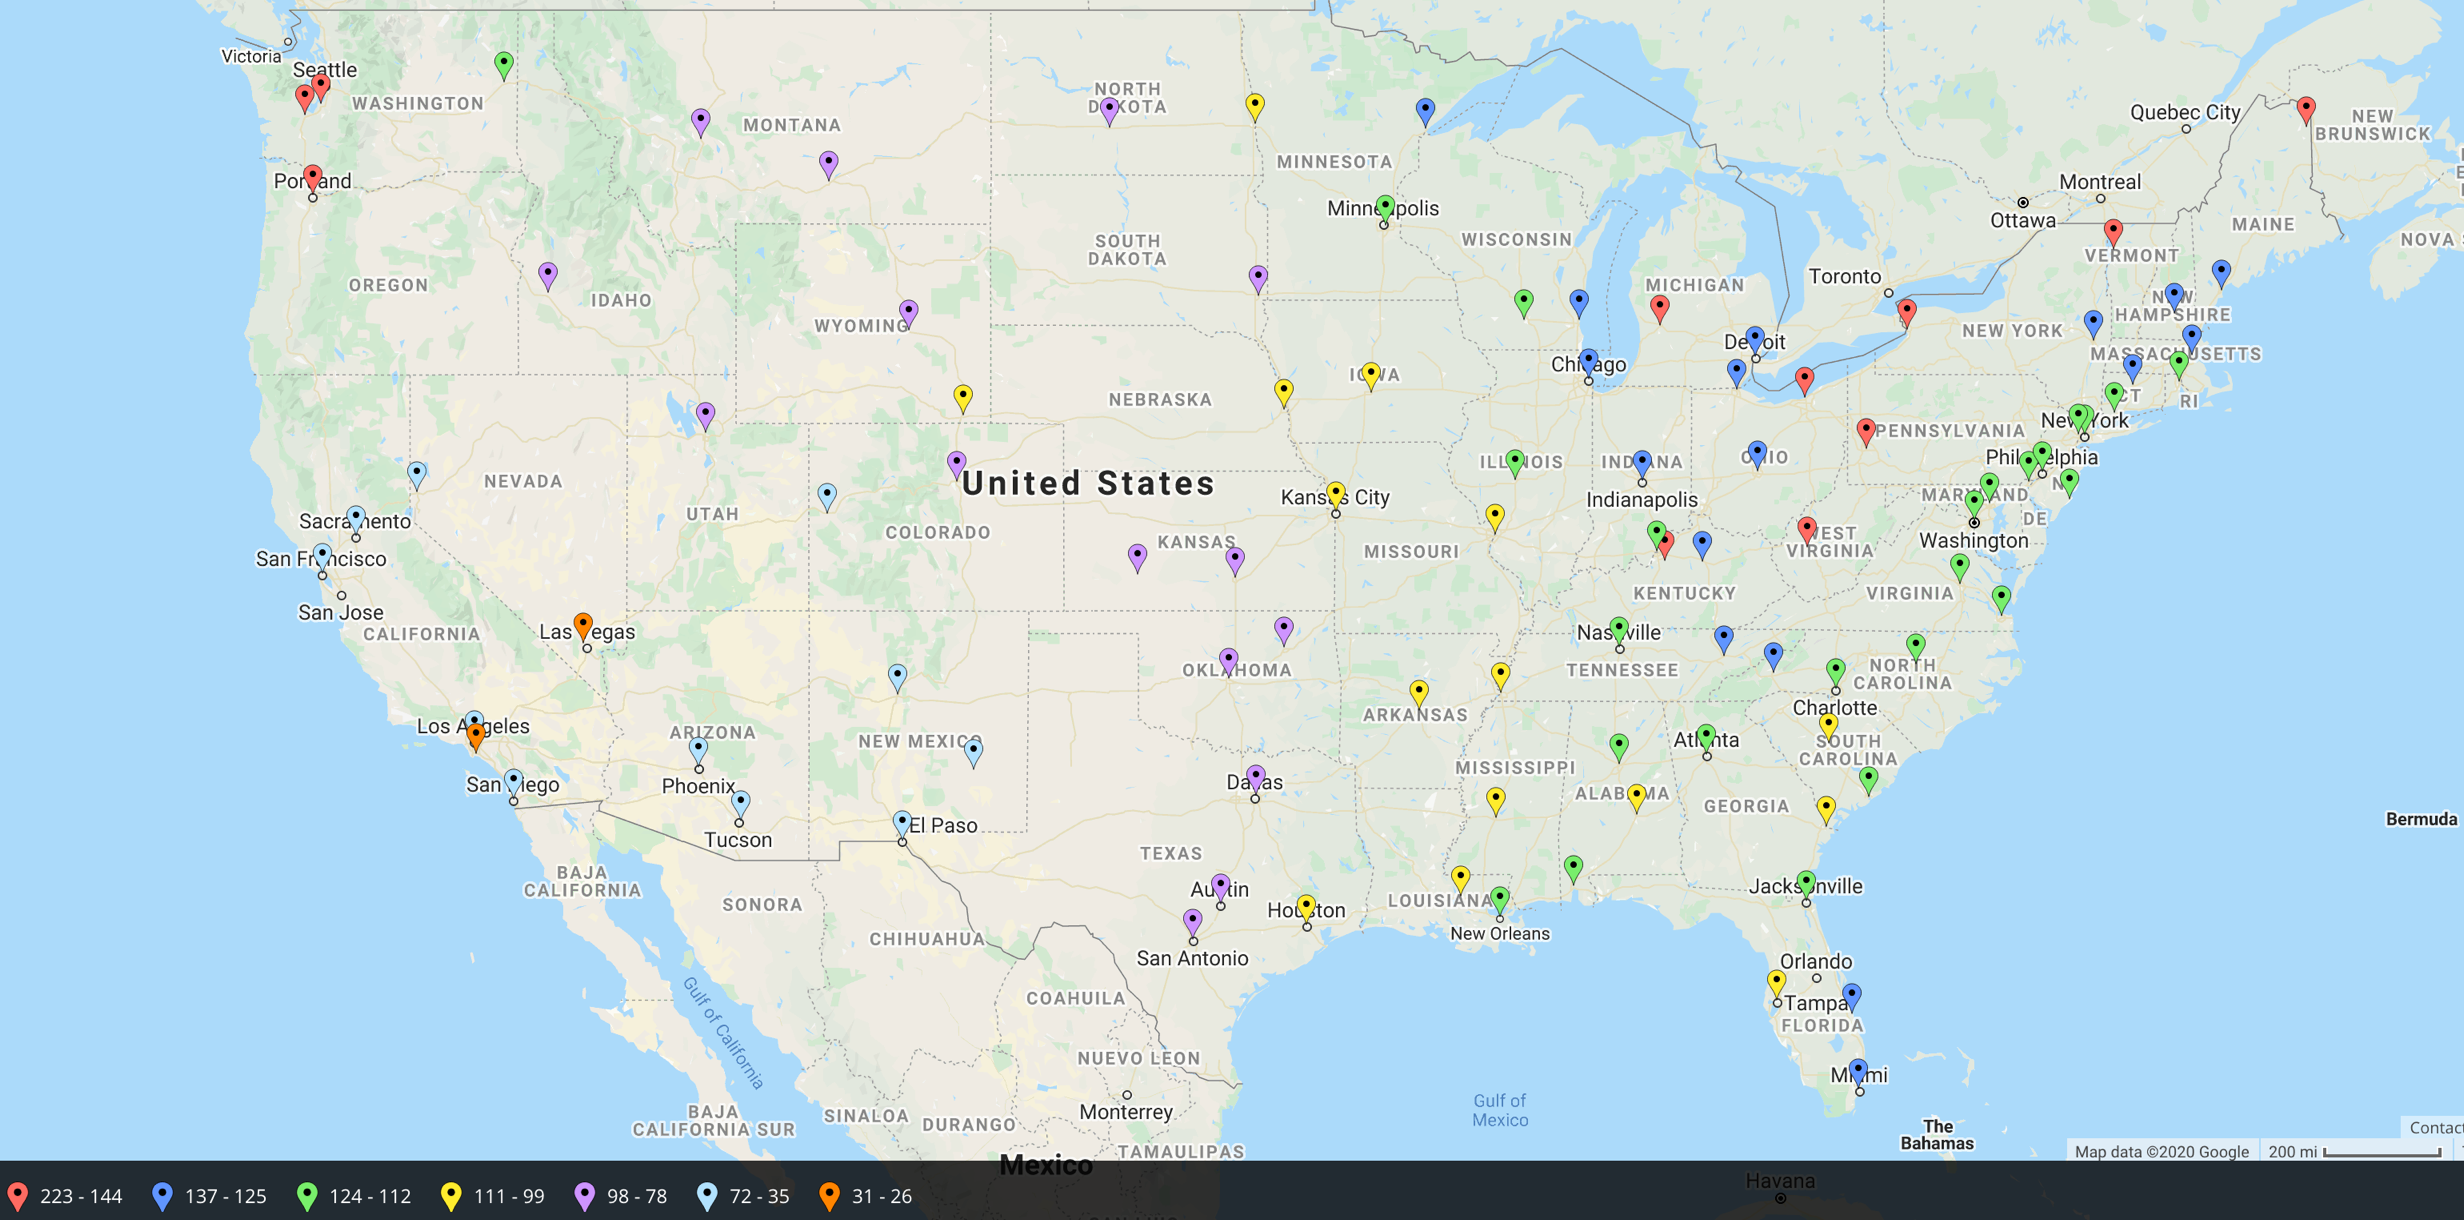

In [788]:
from IPython.display import Image
Image('national_rainfall.png')

Washington is red, indicating that the state experiences rain 144-223 days over the course of the year. Our analysis shows ~157 days of rain each year from 1948-2017. There are a few other states/areas spread about the northeast that experience similar levels to Seattle in terms of rain. Most of the states center in in between 78-137 days of rain each year.

### Rain frequency by year
The previous plot is represents the time series from inception to end. Looking a little deep, did the proportion of rainy days vary across time? Let's check this out over the years elapsed in the time series.

In [789]:
rain_by_year_df = weather_df[['year', 'rain']].groupby(['year', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_year_df = rain_by_year_df.assign(total=rain_by_year_df[False] + rain_by_year_df[True])
rain_by_year_df = rain_by_year_df.assign(rain_proportion = rain_by_year_df[True] / rain_by_year_df.total).drop([False, True, 'total'], axis=1)
rain_by_year_df.head()

rain,year,rain_proportion
0,1948,0.483607
1,1949,0.380822
2,1950,0.531507
3,1951,0.410959
4,1952,0.379781


At first glance, the data looks [mean-reverting](https://mathworld.wolfram.com/ReversiontotheMean.html). There is a strong decline starting in the mid 1970s that oscillates until the 1990s, but this is probably more stochastic than any kind of trend.

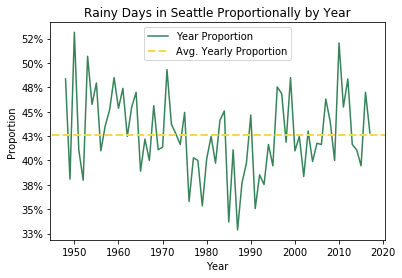

In [790]:
plot = rain_by_year_df.set_index('year').plot(kind='line', legend=False, color=washington_colors[0])
plt.axhline(y=proportion_df.iloc[1, :][1], xmin=-1, xmax=1, color=washington_colors[1], linestyle='--', lw=2)
plt.title('Rainy Days in Seattle Proportionally by Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
vals = plot.get_yticks()
plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plot.legend(['Year Proportion', 'Avg. Yearly Proportion'])
fig = plot.get_figure()
fig.savefig('output4.png', dpi=dpi_value)

### Rain frequency by month

Before we look at frequency of rainy days by month, what would we expect? I have spent a lot of time in Florida and we always expect rain during the summer leading to the fall (hurricane season). Does Seattle fair the same for when rain is expected based on my experience?

In [791]:
rain_by_month_prop = weather_df[['month', 'rain']].groupby(['month', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_month_prop = rain_by_month_prop.assign(total = rain_by_month_prop[False] + rain_by_month_prop[True])
rain_by_month_prop = rain_by_month_prop.assign(rain_proportion = rain_by_month_prop[True] / rain_by_month_prop.total)
rain_by_month_prop = rain_by_month_prop.drop([True, False, 'total'], axis=1).set_index('month')

In [792]:
rain_by_month_prop

rain,rain_proportion
month,
1,0.598157
2,0.557634
3,0.558525
4,0.475238
5,0.355300
6,0.301239
7,0.158065
8,0.190323
9,0.290138


Interestinly, rainy days in the summer is not the case in Seattle. It looks like the least amount of rain days happens during the summer and fall! With the peak amount of rain days occurring during the winter and spring. Something to look further into would be the amount of rain/percipitation. It's possible that there are not as many rainy days in the summer, but when it rains Seattle may experience more rain measured by percipitation in inches.

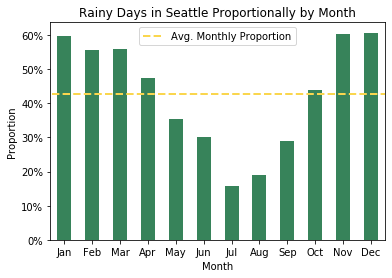

In [793]:
plot = rain_by_month_prop.plot(kind='bar', legend=False, rot=0, color=washington_colors[0])
plt.axhline(y=proportion_df.iloc[1, :][1], xmin=-1, xmax=1, color=washington_colors[1], linestyle='--', lw=2)
plt.title('Rainy Days in Seattle Proportionally by Month')
plt.xlabel('Month')
plt.ylabel('Proportion')
plot.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
vals = plot.get_yticks()
plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plot.legend(['Avg. Monthly Proportion'])
fig = plot.get_figure()
fig.savefig('output5.png', dpi=dpi_value)

## How much actual rainfall occurs (measured in percipitation/inches) in Seattle?

We observed previous that rainy days (categorized as any amount of rain occuring in a day), is least likely during the summer months in Seattle. In this section, we will look further to explore the trends in actual rainfall across year and month.

In [794]:
monthly_mean = weather_df[['month', 'prcp', 'tmax', 'tmin']].groupby(['month']).mean().reset_index()
monthly_mean

,month,prcp,tmax,tmin
0,1,0.183055,45.131797,35.208756
1,2,0.143023,48.994944,36.787664
2,3,0.127963,52.321659,38.393548
3,4,0.088505,57.521905,41.460952
4,5,0.058502,64.309217,46.733180
5,6,0.048522,69.653333,51.628571
6,7,0.023106,75.497696,55.005530
7,8,0.034968,75.233180,55.317512
8,9,0.059057,69.631905,51.754286
9,10,0.119350,59.452535,45.667281


We see a similar U-shape in mean precipitation compared to the proportion of days rained plot. In other words, more actual rain fall occurs in spring and winter with the least amount of rainfall occurring in the summer. Let's see if temperature provides any explanatory power to precipitation.

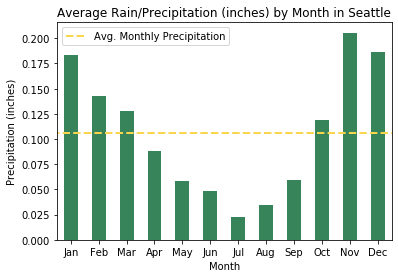

In [795]:
plot = monthly_mean.set_index('month')[['prcp']].plot(kind='bar', rot=0, color=washington_colors[0], legend=False)
plt.axhline(y=monthly_mean.prcp.mean(), xmin=-1, xmax=1, color=washington_colors[1], linestyle='--', lw=2)
plt.title('Average Rain/Precipitation (inches) by Month in Seattle')
plt.xlabel('Month')
plt.ylabel('Precipitation (inches)')
plot.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plot.legend(['Avg. Monthly Precipitation'])
fig = plot.get_figure()
fig.savefig('output6.png', dpi=dpi_value)

Higher temperatures in the summer (obviously) coincide with less rain. This is not too interesting, given its temperature trend is obvious. However, we can look to see if the range between high/low temperature provides more information.

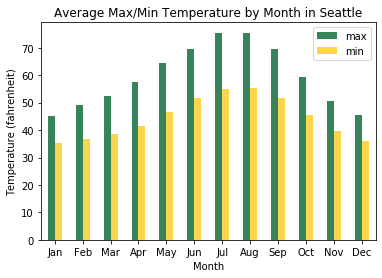

In [796]:
plot = monthly_mean.set_index('month')[['tmax', 'tmin']].plot(kind='bar', rot=0, color=washington_colors)
plt.title('Average Max/Min Temperature by Month in Seattle')
plt.xlabel('Month')
plt.ylabel('Temperature (fahrenheit)')
plot.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plot.legend(['max', 'min'])
fig = plot.get_figure()
fig.savefig('output7.png', dpi=dpi_value)

In [797]:
temp_ranges = monthly_mean.tmax - monthly_mean.tmin

Winter in seattle experiences the most stable period of temperatures, while summer has a wide gap between high/low temperatures.

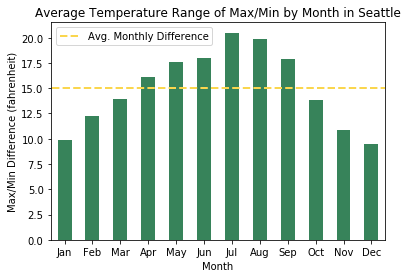

In [798]:
plot = monthly_mean[['month', 'tmax', 'tmin']].assign(max_min_gap = temp_ranges).set_index('month')['max_min_gap'].plot(kind='bar', rot=0, color=washington_colors[0])
plt.axhline(y=temp_ranges.mean(), xmin=-1, xmax=1, color=washington_colors[1], linestyle='--', lw=2)
plt.title('Average Temperature Range of Max/Min by Month in Seattle')
plt.xlabel('Month')
plt.ylabel('Max/Min Difference (fahrenheit)')
plot.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plot.legend(['Avg. Monthly Difference'])
fig = plot.get_figure()
fig.savefig('output8.png', dpi=dpi_value)

## Are there seasonal trends of rain in Seattle?

We have answered this question with the previous visualizations. Rain is persistent in the spring and winter months, while the summer appears to experience the least amount of rain. A quick [interest search](https://cliffmass.blogspot.com/2015/02/why-is-northwest-warm-and-california.html) reveals that Seattle summers are warm and dry for specific meteorological reasons.

## Can we predict Seattle Rain?

Given what's available in the dataset, can we predict whether it will rain on a given day in Seattle? Through our exploration, we have noticed that rainy days can be influenced by the time of year and temperature. Let's use these features to solve the binary classification problem for the variable `rain`.

But first, let's look at more more visualization.

In [799]:
weather_lag_df = weather_df.assign(tmin_lag1 = weather_df.tmin.shift(1),
                                   tmin_lag2 = weather_df.tmin.shift(2),
                                   tmin_lag3 = weather_df.tmin.shift(3),
                                   tmax_lag1 = weather_df.tmax.shift(1),
                                   tmax_lag2 = weather_df.tmax.shift(2),
                                   tmax_lag3 = weather_df.tmax.shift(3),
                                   prcp_lag1 = weather_df.prcp.shift(1),
                                   prcp_lag2 = weather_df.prcp.shift(2),
                                   prcp_lag3 = weather_df.prcp.shift(3))

In [800]:
weather_lag_df = weather_lag_df.dropna().drop(['prcp', 'tmax', 'tmin'], axis=1)
weather_lag_df.head()

,date,year,month,day,rain,tmin_lag1,tmin_lag2,tmin_lag3,tmax_lag1,tmax_lag2,tmax_lag3,prcp_lag1,prcp_lag2,prcp_lag3
3,1948-01-04,1948,1,4,True,35.0,36.0,42.0,45.0,45.0,51.0,0.42,0.59,0.47
4,1948-01-05,1948,1,5,True,34.0,35.0,36.0,45.0,45.0,45.0,0.31,0.42,0.59
5,1948-01-06,1948,1,6,True,32.0,34.0,35.0,45.0,45.0,45.0,0.17,0.31,0.42
6,1948-01-07,1948,1,7,True,39.0,32.0,34.0,48.0,45.0,45.0,0.44,0.17,0.31
7,1948-01-08,1948,1,8,True,40.0,39.0,32.0,50.0,48.0,45.0,0.41,0.44,0.17


### Feature exploration

In [801]:
plot_data = weather_lag_df.iloc[random.sample(list(weather_lag_df.reset_index().index), 1500), :]
plot_data.loc[:, 'rain'] = np.where(plot_data.loc[:, 'rain'], 'rain', 'no rain')

/Users/joshuagoldberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


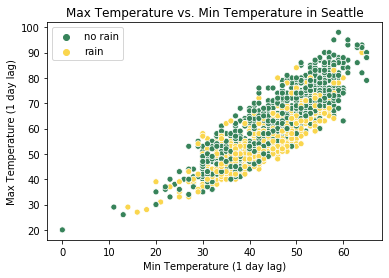

In [802]:
plot = sns.scatterplot(x='tmin_lag1', y='tmax_lag1', hue='rain', data=plot_data, palette=washington_colors)
plot.set(title='Max Temperature vs. Min Temperature in Seattle', 
         xlabel='Min Temperature (1 day lag)', 
         ylabel='Max Temperature (1 day lag)')
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[1:], labels=labels[1:])
fig = plot.get_figure()
fig.savefig('output9.png', dpi=dpi_value)

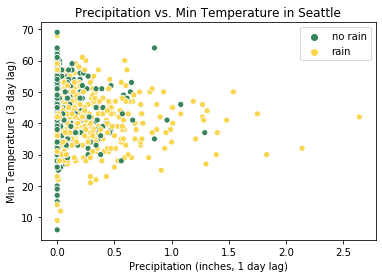

In [803]:
plot = sns.scatterplot(x='prcp_lag1', y='tmin_lag3', hue='rain', data=plot_data, palette=washington_colors)
plot.set(title='Precipitation vs. Min Temperature in Seattle', 
         xlabel='Precipitation (inches, 1 day lag)', 
         ylabel='Min Temperature (3 day lag)')
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[1:], labels=labels[1:])
fig = plot.get_figure()
fig.savefig('output10.png', dpi=dpi_value)

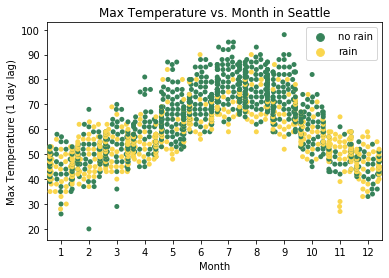

In [804]:
plot = sns.swarmplot(x='month', y='tmax_lag1', hue='rain', data=plot_data, palette=washington_colors)
plot.set(title='Max Temperature vs. Month in Seattle', 
         xlabel='Month', 
         ylabel='Max Temperature (1 day lag)')
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles, labels=labels)
fig = plot.get_figure()
fig.savefig('output11.png', dpi=dpi_value)

Taking a quick look at the proportion of class occurrences reveals what we saw earlier in our exploration: our classes are pretty balanced.

In [706]:
X = weather_lag_df[weather_lag_df['year'] < 1990].drop(['rain', 'year', 'date'], axis=1)
scaler = preprocessing.StandardScaler().fit(X)

X = scaler.transform(X)
y = weather_lag_df[weather_lag_df['year'] < 1990].loc[:, 'rain']
y = np.where(y, 1, 0)
rain_count = collections.Counter(y)
rain_count['No rain'] = rain_count.pop(0)
rain_count['Rain'] = rain_count.pop(1)
rain_count = pd.DataFrame.from_dict(rain_count, orient='index').reset_index()
rain_count.columns = ['Weather', 'Days Count']
rain_count

,Weather,Days Count
0,No rain,8808
1,Rain,6530


We will use data leading up to the year 1990 for training/cross validation. All data 1990 and greater will be used for holdout. Additionally, we will scale the data to ensure no feature dominates the modeling process.

In [216]:
# Split our data for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# create a dictionary of parameters
param_grid = {'n_estimators': [100, 250, 500, 1000], 'max_depth': [3, 5, 10, 15, 20],
              "max_features": [1, 3, 5]}

# create random forest model
rf_obj = RandomForestClassifier()

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Create gridsearch object with various combinations of parameters
rf_grid = GridSearchCV(rf_obj, param_grid, cv=tscv, 
                       scoring=scoring, n_jobs=-1, verbose=0,
                       refit='AUC', return_train_score=True)

In [217]:
%%time
rf_grid.fit(X, y)

CPU times: user 3.59 s, sys: 229 ms, total: 3.82 s
Wall time: 5min 58s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_f...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
     

Now that we have cross validation results, let's check for overfitting. We will focus on `max_depth`.

In [807]:
results = rf_grid.cv_results_
train_res = pd.DataFrame({'data': 'train', 'auc': results['mean_train_AUC']})
test_res = pd.DataFrame({'data': 'test', 'auc': results['mean_test_AUC']})
max_depth_df = pd.DataFrame({'max_depth': results['param_max_depth']})
plot_model = pd.concat([pd.concat([train_res, test_res], axis=0), pd.concat([max_depth_df, max_depth_df])], axis=1)
plot_model.head()

,data,auc,max_depth
0,train,0.779212,5
1,train,0.779685,5
2,train,0.780703,5
3,train,0.780834,5
4,train,0.792079,5


The model quickly begins to overfit with `max_depth` increasing. From sklearn documentation: 
> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In other words, an unlimited max depth will allow the tree to grow to the extend that it fits the data perfectly. This is something we want to avoid to achieve a better [generalized](https://en.wikipedia.org/wiki/Generalization_error) result when modeling. 

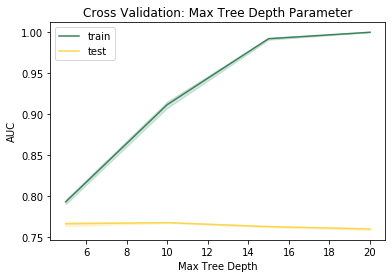

In [808]:
plot = sns.lineplot(x='max_depth', y='auc', hue='data', data=plot_model, palette=washington_colors)
plot.set(title='Cross Validation: Max Tree Depth Parameter', 
         xlabel='Max Tree Depth',
         ylabel='AUC')
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[1:], labels=labels[1:])
fig = plot.get_figure()
fig.savefig('output12.png', dpi=dpi_value)

In [809]:
best_params = rf_grid.best_params_
print(f'Grid search selected the following best parameters based on AUC: max_depth: {best_params["max_depth"]}, max_features: {best_params["max_features"]}, and n_estimators: {best_params["n_estimators"]}.')

Grid search selected the following best parameters based on AUC: max_depth: 5, max_features: 4, and n_estimators: 250.


In [761]:
rf_best_model = rf_grid.best_estimator_

Let's run our cross validation results with a holdout () data set.

In [810]:
X_holdout = weather_lag_df[weather_lag_df['year'] >= 1990].drop(['rain', 'year', 'date'], axis=1)
X_holdout = scaler.transform(X_holdout)
y_holdout = weather_lag_df[weather_lag_df['year'] >= 1990].loc[:, 'rain']
y_holdout = np.where(y_holdout, 1, 0)
rain_count = collections.Counter(y_holdout)
rain_count['No rain'] = rain_count.pop(0)
rain_count['Rain'] = rain_count.pop(1)
rain_count = pd.DataFrame.from_dict(rain_count, orient='index').reset_index()
rain_count.columns = ['Weather', 'Days Count']
rain_count

,Weather,Days Count
0,No rain,5834
1,Rain,4367


In [813]:
from matplotlib.colors import LinearSegmentedColormap

boundaries = [0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]  # custom boundaries

# here I generated twice as many colors, 
# so that I could prune the boundaries more clearly
hex_colors = sns.light_palette(washington_colors[0], n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]

colors=list(zip(boundaries, hex_colors))

custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)

              precision    recall  f1-score   support

        rain       0.73      0.81      0.77      5834
     no rain       0.70      0.61      0.65      4367

    accuracy                           0.72     10201
   macro avg       0.72      0.71      0.71     10201
weighted avg       0.72      0.72      0.72     10201



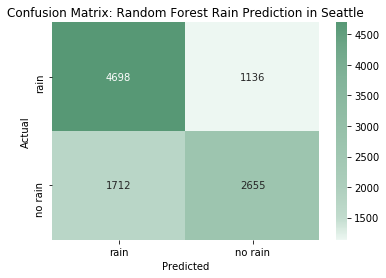

In [814]:
y_test_pred = rf_best_model.predict(X_holdout)
labels_df = pd.DataFrame({'rain': y_holdout})
labels = labels_df.drop_duplicates(
).sort_values('rain')
labels = labels.assign(label=['rain', 'no rain'])

conf_mat = metrics.confusion_matrix(y_true=y_holdout, y_pred=y_test_pred)
fig, ax = plt.subplots(figsize=(6, 4))
plot = sns.heatmap(conf_mat, annot=True, fmt="d",
                   xticklabels=labels.label.values,
                   yticklabels=labels.label.values, 
                   cmap=custom_color_map)
plot.set(title='Confusion Matrix: Random Forest Rain Prediction in Seattle', 
         xlabel='Predicted',
         ylabel='Actual')
fig = plot.get_figure()
fig.savefig('output12.png', dpi=dpi_value)

print(metrics.classification_report(y_holdout, y_test_pred, target_names=labels.label.values))

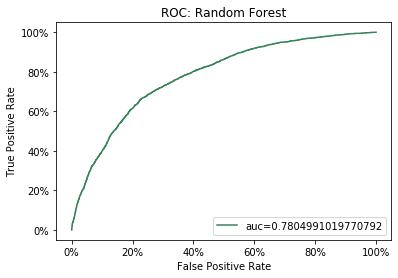

In [815]:
logistic_scores = rf_best_model.predict_proba(X_holdout)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_holdout, logistic_scores)
auc = metrics.roc_auc_score(y_holdout, logistic_scores)
auc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
plot = auc_data.plot(x='fpr', y='tpr', label="auc=" + str(auc), color=washington_colors[0])
vals = plot.get_xticks()
plot.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
vals = plot.get_yticks()
plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title('ROC: Random Forest') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.savefig('output13.png', dpi=dpi_value)
plt.show()

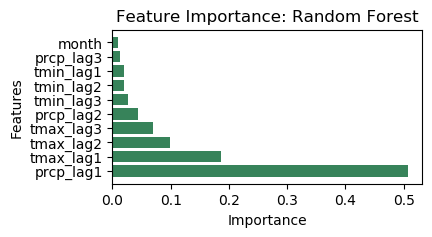

In [816]:
importances = rf_best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking    
headers = ["name", "score"]
values_rf = sorted(zip(weather_lag_df.drop(['rain', 'year', 'date'], axis=1).columns, importances), key=lambda x: x[1] * -1)
# print(tabulate(values_rf[0:10], headers, tablefmt="plain"))

# Plot the feature importances of the forest
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.barh(pd.DataFrame(values_rf[0:10]).iloc[:, 0], importances[indices][0:10], align='center', color=washington_colors[0])
plt.title('Feature Importance: Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('output14.png', dpi=dpi_value)
plt.show()

## What did we learn?

Generally speaking, Seattle experiences a high number of rainy days compared to the rest of the country. However, if we look at actual rainfall, [Seattle ranks](http://www.usa.com/rank/us--average-precipitation--state-rank.htm) in the middle of the pack. 

Anecdotally, Seattle's rain is known to be light and misty. Whether rain is light or heavy, generally it comes with a lack of sunshine.

We also learned that the summers are dry and warm. Seattle summers are [rumored](https://www.thrillist.com/entertainment/seattle/17-reasons-seattle-summers-dominate-all-other-summers) to be a blast — probably driven by the mild summer weather. The winter looks predictable as the high/low temperature range is narrow. While you may see more days of rain in the winter, you can expect to wear similar layers to fend off the chilly air. Lastly, to determine if it will rain tomorrow, our analysis showed that yesterday's precipitation and and temperature can help us come to a reasonably accurate prediction.

If you have made it this far, you have learned some facts about Seattle's rain. Whether you are in a conversation or visiting sometime soon, I hope this information helps you in your high debates about Seattle weather or your travel.